# PostBOUND presentation @ BTW'23


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import pandas as pd
import seaborn as sns

from analysis import selection
from transform import mosp
from postgres import explain


In [3]:
sns.set_style("white")

In [4]:
def read_workload(path: str, optimizer: str, nlj: bool):
    df = pd.read_csv(path)
    df["optimizer"] = optimizer
    df["nlj"] = "on" if nlj else "off"

    df.rename(columns={"query_rt_total": "exec_time"}, inplace=True)
    df = selection.best_query_repetition(df, group_cols="label", performance_col="exec_time")
    df = selection.reorder(df, "label")
    df.set_index("label", inplace=True)

    return df

job_nat = read_workload("../workloads/job-results-implicit.csv", "native", True)
job_nat_nonlj = read_workload("../workloads/job-results-implicit-nonlj.csv", "native", False)
job_ues = read_workload("../workloads/job-ues-results-base.csv", "ues", False)

workload_results = pd.concat([job_nat, job_nat_nonlj, job_ues])
workload_results.groupby(["optimizer", "nlj"]).exec_time.describe()


count      mean        std       min       25%       50%  \
optimizer nlj                                                             
native    off  113.0  7.504811  31.659038  0.012763  1.547933  3.559108   
          on   113.0  3.568947   8.565507  0.005737  0.119188  0.663484   
ues       off  113.0  3.336197   2.144219  0.010616  1.674846  2.843448   

                    75%         max  
optimizer nlj                        
native    off  5.159605  254.467602  
          on   2.839030   60.260257  
ues       off  4.979541    9.002675

In [5]:
workload_results.groupby(["optimizer", "nlj"]).exec_time.sum()

optimizer  nlj
native     off    848.043627
           on     403.290958
ues        off    376.990205
Name: exec_time, dtype: float64

<AxesSubplot:xlabel='label', ylabel='exec_time'>

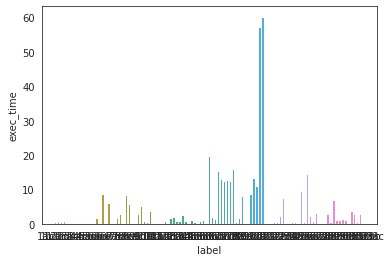

In [6]:
sns.barplot(data=job_nat.reset_index(), x="label", y="exec_time")


<AxesSubplot:xlabel='label', ylabel='exec_time'>

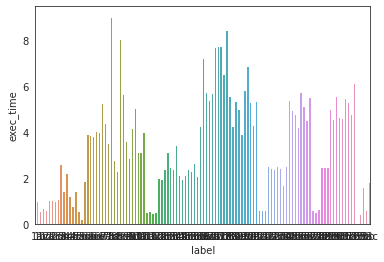

In [7]:
sns.barplot(data=job_ues.reset_index(), x="label", y="exec_time")


## Best operator selection/subquery improvement


In [8]:
job_nat = read_workload("../workloads/job-results-implicit-nonlj.csv", "native", False)
job_nat["query"] = job_nat["query"].apply(mosp.MospQuery.parse)
job_nat["query_result"] = job_nat["query_result"].apply(json.loads)
job_nat["query_plan"] = job_nat.apply(lambda res: explain.parse_explain_analyze(res.query, res.query_result, with_subqueries=False), axis=1)

/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Hash
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Aggregate
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Gather
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Sort
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Gather Merge
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknow

In [9]:
job_ues = read_workload("../workloads/job-ues-results-idxnlj.csv", "ues", False)
job_ues["query"] = job_ues["query"].apply(mosp.MospQuery.parse)
job_ues["n_subqueries"] = job_ues["query"].apply(lambda q: len(q.subqueries()))
job_ues["query_result"] = job_ues["query_result"].apply(json.loads)
job_ues["query_plan"] = job_ues.apply(lambda res: explain.parse_explain_analyze(res.query, res.query_result, with_subqueries=True), axis=1)


/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Hash
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Aggregate
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Gather
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Sort
  warnings.warn("Unknown node type: {}".format(node_type))
/home/rico/Projekte/Uni/DiplomArbeit-QueryOpt/postbound/postgres/explain.py:502: UserWarning: Unknown node type: Gather Merge
  warnings.warn("Unknown node type: {}".format(node_type))


In [10]:
workload_results = pd.merge(job_nat[["query", "exec_time", "query_plan"]], job_ues[["exec_time", "query_plan", "n_subqueries"]],
                            left_index=True, right_index=True, suffixes=("_native", "_ues"))
workload_results["n_tables"] = workload_results["query"].apply(lambda q: len(q.collect_tables()))
workload_results["ues_speedup"] = workload_results["exec_time_native"] - workload_results["exec_time_ues"]
hinted_queries = workload_results[workload_results.n_subqueries > 0]


In [11]:
hinted_queries.sort_values(by="ues_speedup", ascending=False)[["ues_speedup", "n_tables"]].head()


,ues_speedup,n_tables
label,,
19d,246.876995,10
8c,221.735417,7
8d,3.001687,7
7b,2.189913,8
26a,1.868168,12


In [12]:
example_query = hinted_queries.loc["8c"]
example_query


query                SELECT COUNT(*) FROM aka_name AS a1, cast_info...
exec_time_native                                            228.443956
query_plan_native    Hash Join (n1.id = a1.person_id) <- [Seq Scan ...
exec_time_ues                                                 6.708539
query_plan_ues       Hash Join (mc.company_id = cn.id) <- [Hash Joi...
n_subqueries                                                         1
n_tables                                                             7
ues_speedup                                                 221.735417
Name: 8c, dtype: object

In [13]:
example_query.query_plan_native.pretty_print(include_exec_time=True)


Hash Join (n1.id = a1.person_id) (95.546s)
  <- Seq Scan :: name (0.378s)
  <- Hash Join (ci.person_id = a1.person_id) (7.174s)
    <- Hash Join (mc.movie_id = ci.movie_id) (6.492s)
      <- Hash Join (mc.company_id = cn.id) (0.400s)
        <- Seq Scan :: movie_companies (0.121s)
        <- Seq Scan :: company_name (0.017s)
      <- Hash Join (t.id = ci.movie_id) (5.195s)
        <- Seq Scan :: title (0.182s)
        <- Hash Join (ci.role_id = rt.id) (3.393s)
          <- Seq Scan :: cast_info (1.520s)
          <- Seq Scan :: role_type (0.000s)
    <- Seq Scan :: aka_name (0.057s)



In [14]:
example_query.query_plan_ues.pretty_print(include_exec_time=True)


Hash Join (mc.company_id = cn.id) (6.491s)
  <- Hash Join (mc.movie_id = ci.movie_id) (6.064s)
    <- Seq Scan :: movie_companies (0.167s)
    <- Hash Join (ci.person_id = a1.person_id) (4.905s)
      <- Hash Join (t.id = ci.movie_id) (3.210s)
        <- Seq Scan :: title (0.174s)
        <- Nested Loop (ci.role_id = rt.id) (1.262s)
          <- Seq Scan :: role_type (0.000s)
          <- Index Scan :: cast_info (0.825s)
      <- Hash Join (a1.person_id = n1.id) (0.865s)
        <- Seq Scan :: aka_name (0.046s)
        <- Seq Scan :: name (0.223s)
  <- Seq Scan :: company_name (0.015s)

